*Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает.*

**Задача:** спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!
* импортируем нужные библиотеки:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import orbit
from orbit.eda import eda_plot
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.metrics import rmsse

import pandahouse as ph
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Любое целевое действие пользователя (просмотры, лайки) на платформе отражается на нагрузку сервера.
Поэтому за основную метрику для прогноза нагрузки мы возьмем **кол-во действий (лайки и просмотры)**
Регрессор будет один - DAU, т.к., думаю, корреляция между кол-вом действий и кол-вом пользователей должна быть достаточно высокая.
Возьмем временное разрешение в один час.

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [68]:
q = """
SELECT 
    toStartOfHour(f.time) as hour_date,
     count() as actions,
    uniqExact(f.user_id) as users
FROM
    simulator_20241120.feed_actions as f
WHERE
    toDate(f.time) < today()
GROUP BY
    hour_date
ORDER BY
    hour_date    
"""


df = ph.read_clickhouse(q, connection=connection)

In [69]:
df.head(10)

hour_date  actions  users
0 2024-09-28 00:00:00       22     14
1 2024-09-28 01:00:00       32     26
2 2024-09-28 02:00:00       24     16
3 2024-09-28 03:00:00       11     11
4 2024-09-28 04:00:00       18     14
5 2024-09-28 05:00:00       19     14
6 2024-09-28 06:00:00       27     22
7 2024-09-28 07:00:00       36     29
8 2024-09-28 08:00:00       35     29
9 2024-09-28 09:00:00       41     29

In [70]:
df = df.astype({"actions": np.int64, "users": np.int64})

In [6]:
sns.set(rc={'figure.figsize':(20,10)}, style='whitegrid')

<Axes: xlabel='hour_date', ylabel='actions'>

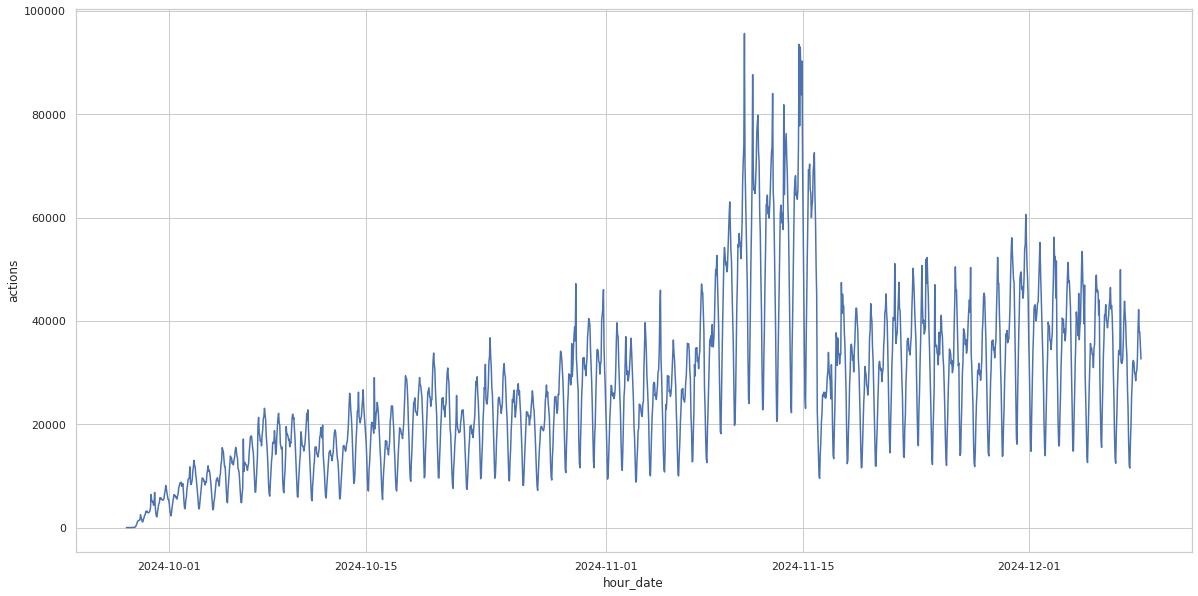

In [7]:
sns.lineplot(data=df, x='hour_date', y='actions')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

(<Axes: title={'center': 'actions (Mean) Time Series Heatmap'}, xlabel='seasonal_interval', ylabel='y_axis_interval'>,
       index           hour_date  actions  seasonal_interval  y_axis_interval
 0         0 2024-09-28 00:00:00       22                  0                0
 1         1 2024-09-28 01:00:00       32                  0                1
 2         2 2024-09-28 02:00:00       24                  0                2
 3         3 2024-09-28 03:00:00       11                  0                3
 4         4 2024-09-28 04:00:00       18                  0                4
 ...     ...                 ...      ...                ...              ...
 1723   1723 2024-12-08 19:00:00    42203                 71               19
 1724   1724 2024-12-08 20:00:00    37821                 71               20
 1725   1725 2024-12-08 21:00:00    37880                 71               21
 1726   1726 2024-12-08 22:00:00    35150                 71               22
 1727   1727 2024-12-08

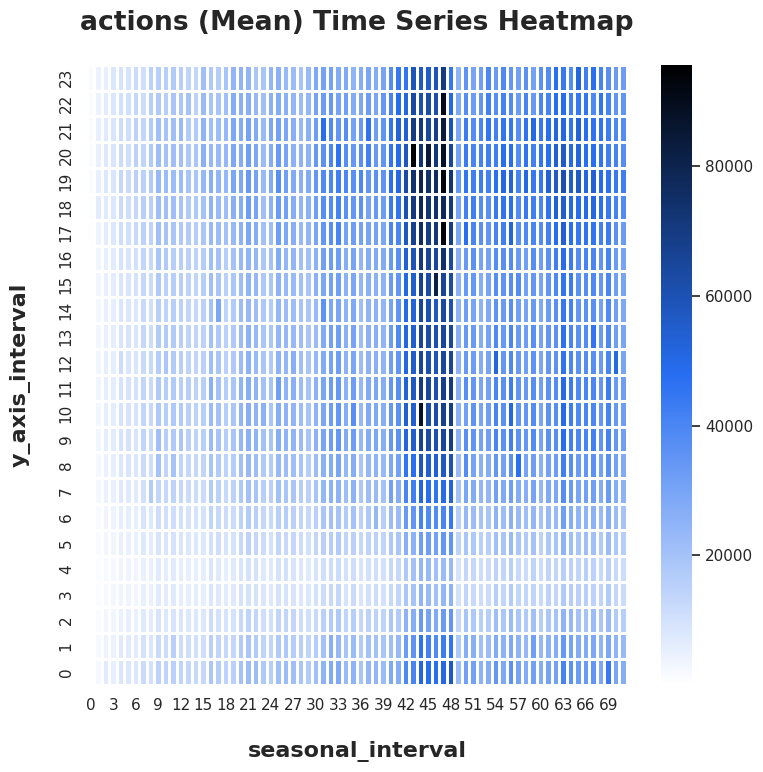

In [8]:
eda_plot.ts_heatmap(df=df, date_col = 'hour_date', value_col = 'actions', seasonal_interval=24, normalization=False)

На графиках заметно увеличение активности пользователей во время флешмоба. Однако это увеличение оказалось всего лишь "вспышкой", после чего метрика вернулась в своё "русло".

План действий:
1. Разобъем наш датайфрем на 2: тренировочные и тестовые данные. Т.к. нам нужно прогнозировать месяц, то возьмем от текущей даты месяц назад. 
2. Построим различные модели на основе Orbit, обучим их, спрогнозируем метрику и сравним ее с реальными данными
3. Сравним модели по критериям и попробуем определить лучшую модель
4. На основе лучшей модели спрогнозируем будущую нагрузку на сервера
5. Подведем итоги

* Разобъем наш датайфрем на 2: тренировочные и тестовые данные

In [9]:
df.head()

hour_date  actions  users
0 2024-09-28 00:00:00       22     14
1 2024-09-28 01:00:00       32     26
2 2024-09-28 02:00:00       24     16
3 2024-09-28 03:00:00       11     11
4 2024-09-28 04:00:00       18     14

In [10]:
prev_month = df.hour_date.max() - pd.DateOffset(months=1)

In [71]:
train_df = df.query('hour_date < @prev_month')
test_df = df.query('hour_date >= @prev_month')

In [12]:
train_df.head(10)

hour_date  actions  users
0 2024-09-28 00:00:00       22     14
1 2024-09-28 01:00:00       32     26
2 2024-09-28 02:00:00       24     16
3 2024-09-28 03:00:00       11     11
4 2024-09-28 04:00:00       18     14
5 2024-09-28 05:00:00       19     14
6 2024-09-28 06:00:00       27     22
7 2024-09-28 07:00:00       36     29
8 2024-09-28 08:00:00       35     29
9 2024-09-28 09:00:00       41     29

In [13]:
test_df.head(10)

hour_date  actions  users
1007 2024-11-08 23:00:00    44634   1267
1008 2024-11-09 00:00:00    39470   1128
1009 2024-11-09 01:00:00    32347    920
1010 2024-11-09 02:00:00    25251    730
1011 2024-11-09 03:00:00    18568    551
1012 2024-11-09 04:00:00    18181    584
1013 2024-11-09 05:00:00    26297    817
1014 2024-11-09 06:00:00    33393   1062
1015 2024-11-09 07:00:00    40108   1247
1016 2024-11-09 08:00:00    45487   1482

* Построим модель на основе алгоритма 'stan-map'. В разрабатываемых моделях будем использовать логистический тренд, т.к. у нас по идее должны быть только положительные значения:

In [88]:
model_map = DLT(response_col="actions", #название колонки с метрикой
                date_col="hour_date", #название колонки с датами-временем
                seasonality=24, #длина периода сезонности 
                estimator="stan-map", #алгоритм оценки
                n_bootstrap_draws=1000, #количество сэмплов бутстрапа для доверительного интервала
                global_trend_option='logistic',
                global_cap=100000,
                global_floor=1
               ) 

model_map.fit(train_df)

2024-12-09 14:12:55 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

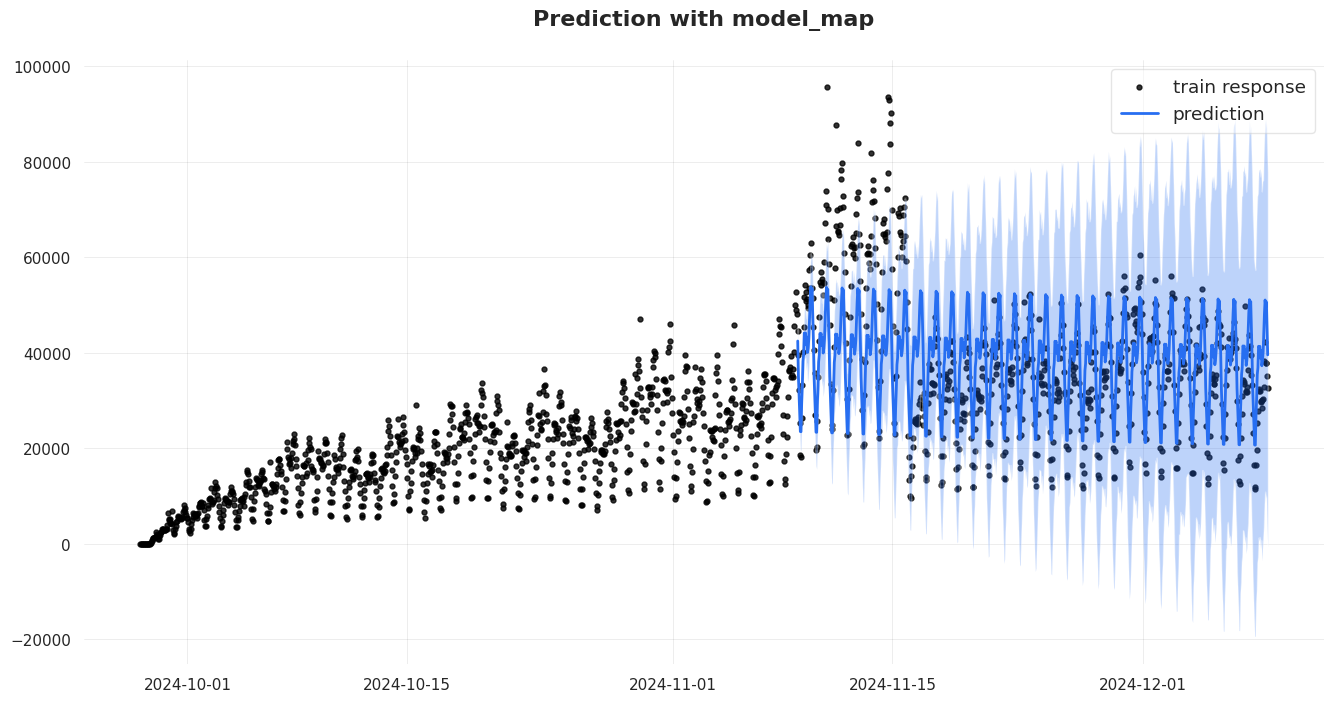

<Axes: title={'center': 'Prediction with model_map'}>

In [89]:
model_map_predicted_df = model_map.predict(df=test_df, decompose=True)

plot_predicted_data(df, #изначальные данные
                    model_map_predicted_df, #датафрейм с предсказаниями
                    "hour_date", #колонка со временем
                    'actions', #колонка со значениями временного ряда
                    title='Prediction with model_map') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

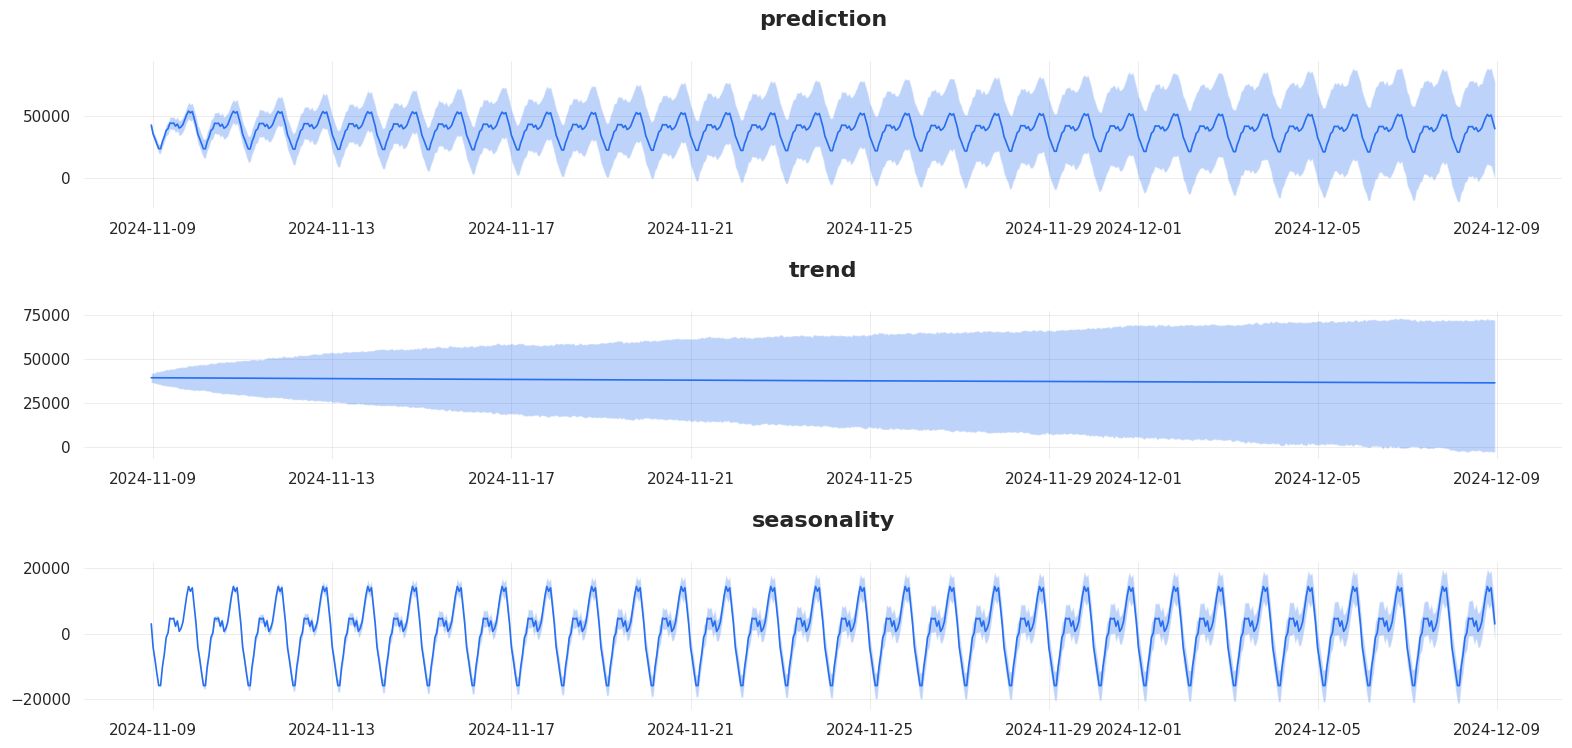

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>], dtype=object)

In [90]:
plot_predicted_components(model_map_predicted_df, "hour_date", plot_components=['prediction', 'trend', 'seasonality'])

* Построим модель на основе алгоритма 'stan-map' с регрессором DAU и видом регуляризации по умолчанию:

In [91]:
model_map_with_regressor = DLT(response_col="actions", #название колонки с метрикой
                               date_col="hour_date", #название колонки с датами-временем
                               seasonality=24, #длина периода сезонности 
                               estimator="stan-map", #алгоритм оценки
                               n_bootstrap_draws=1000, #количество сэмплов бутстрапа для доверительного интервала
                               regressor_col=["users"], #наша колонка с регрессором! Должна быть списком
                               regressor_sign=["+"], # знак коэффициента регрессии, ожидаем только положительные значения
                               regression_penalty='fixed_ridge', # вид регуляризации = полагаться на заданные априорные распределения
                               global_trend_option='logistic',
                               global_cap=100000,
                               global_floor=1                            
                              )  

model_map_with_regressor.fit(train_df)

2024-12-09 14:13:00 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

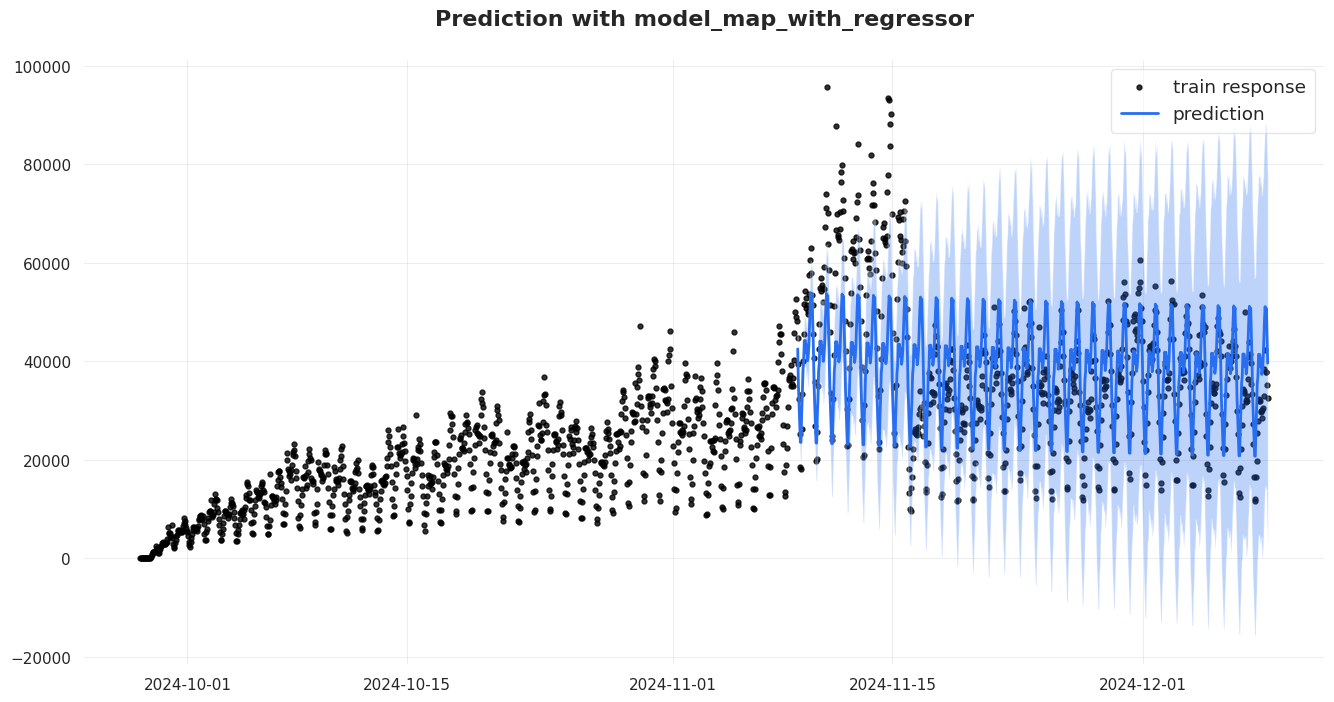

<Axes: title={'center': 'Prediction with model_map_with_regressor'}>

In [92]:
model_map_with_regressor_predicted_df = model_map_with_regressor.predict(df=test_df, decompose=True)

plot_predicted_data(df, #изначальные данные
                    model_map_with_regressor_predicted_df, #датафрейм с предсказаниями
                    "hour_date", #колонка со временем
                    'actions', #колонка со значениями временного ряда
                    title='Prediction with model_map_with_regressor') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

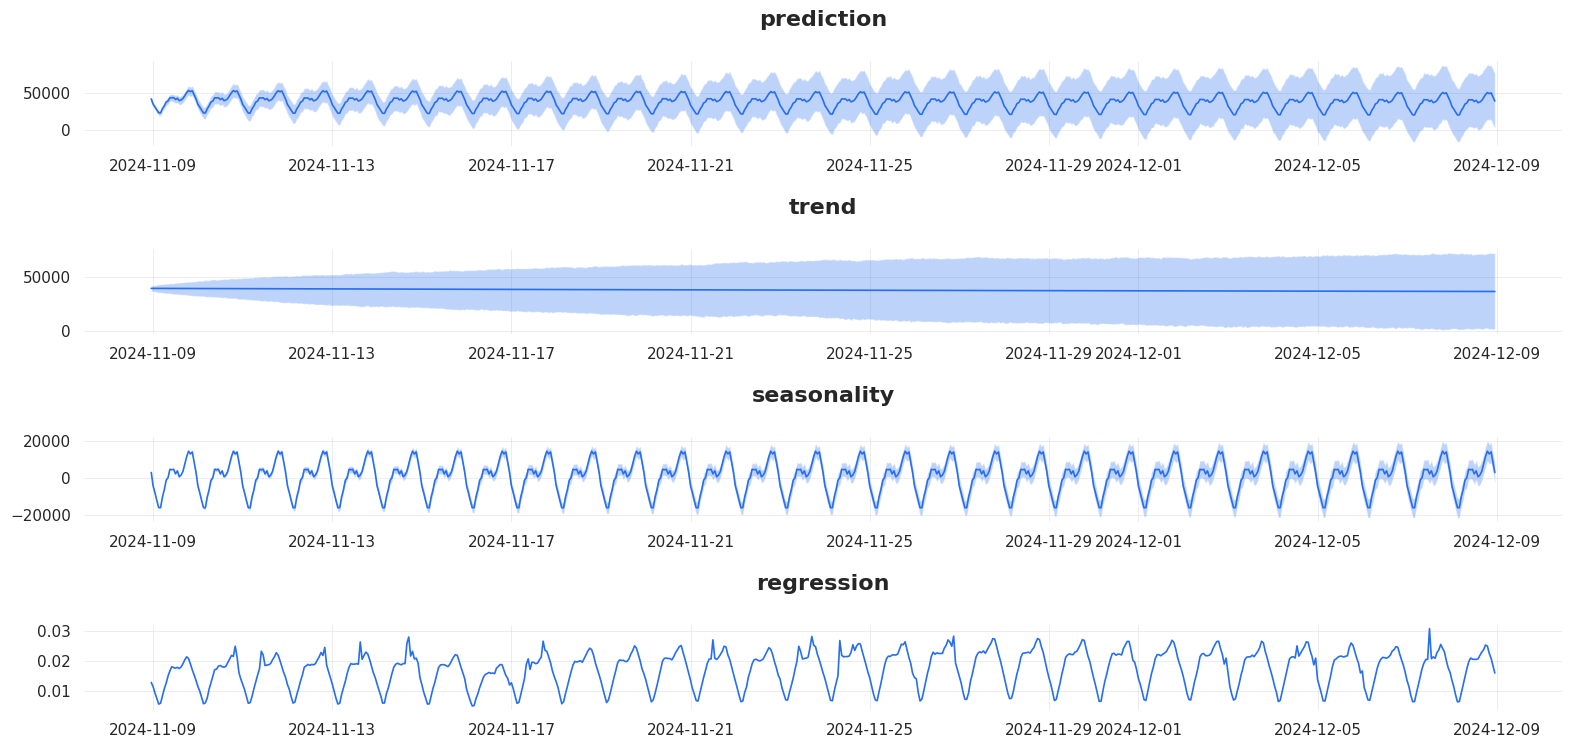

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>,
       <Axes: title={'center': 'regression'}>], dtype=object)

In [93]:
plot_predicted_components(model_map_with_regressor_predicted_df, "hour_date", plot_components=['prediction', 'trend', 'seasonality', 'regression'])

* Построим модель на основе алгоритма 'stan-map' с регрессором DAU и авто подбором оптимальной регуляризации:

In [94]:
model_map_with_auto_ridge = DLT(response_col="actions", #название колонки с метрикой
                                date_col="hour_date", #название колонки с датами-временем
                                seasonality=24, #длина периода сезонности 
                                estimator="stan-map", #алгоритм оценки
                                n_bootstrap_draws=1000, #количество сэмплов бутстрапа для доверительного интервала
                                regressor_col=["users"], #наша колонка с регрессором! Должна быть списком
                                regressor_sign=["+"], # знак коэффициента регрессии
                                regression_penalty='auto_ridge', # вид регуляризации = авто подбор оптимальной регуляризации
                                global_trend_option='logistic',
                                global_cap=100000,
                                global_floor=1 
                               ) 

model_map_with_auto_ridge.fit(train_df)

2024-12-09 14:13:05 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

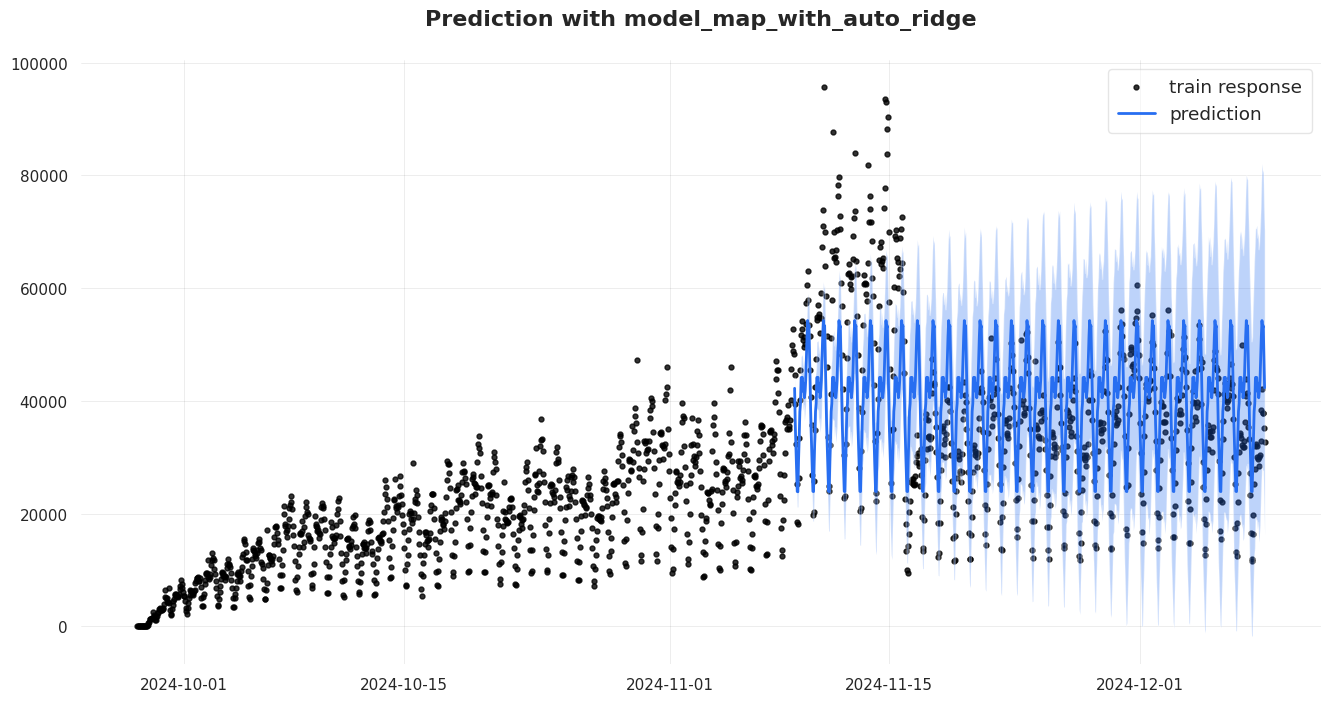

<Axes: title={'center': 'Prediction with model_map_with_auto_ridge'}>

In [95]:
model_map_with_auto_ridge_predicted_df = model_map_with_auto_ridge.predict(df=test_df, decompose=True)

plot_predicted_data(df, #изначальные данные
                    model_map_with_auto_ridge_predicted_df, #датафрейм с предсказаниями
                    "hour_date", #колонка со временем
                    'actions', #колонка со значениями временного ряда
                    title='Prediction with model_map_with_auto_ridge') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

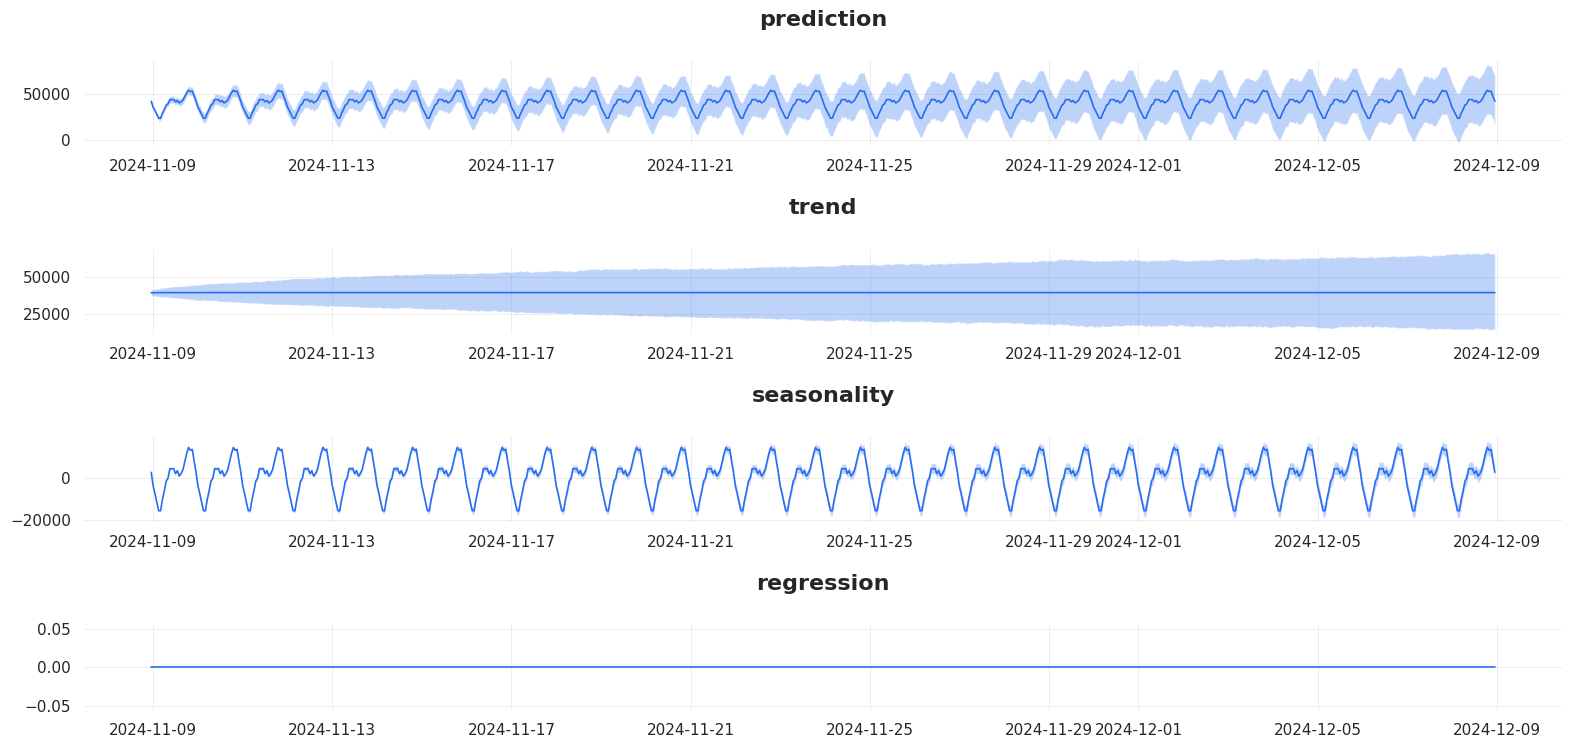

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>,
       <Axes: title={'center': 'regression'}>], dtype=object)

In [96]:
plot_predicted_components(model_map_with_auto_ridge_predicted_df, "hour_date", plot_components=['prediction', 'trend', 'seasonality', 'regression'])

* Построим модель на основе алгоритма 'stan-map' с регрессором DAU и с упразднением влияния плохих регрессоров:

In [97]:
model_map_with_lasso = DLT(response_col="actions", #название колонки с метрикой
                           date_col="hour_date", #название колонки с датами-временем
                           seasonality=24, #длина периода сезонности 
                           estimator="stan-map", #алгоритм оценки
                           n_bootstrap_draws=1000, #количество сэмплов бутстрапа для доверительного интервала
                           regressor_col=["users"], #наша колонка с регрессором! Должна быть списком
                           regressor_sign=["+"], # знак коэффициента регрессии
                           regression_penalty='lasso', # вид регуляризации = “убирает” влияние плохих регрессоров
                           global_trend_option='logistic',
                           global_cap=100000,
                           global_floor=1 
                          ) 

model_map_with_lasso.fit(train_df)

2024-12-09 14:13:13 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

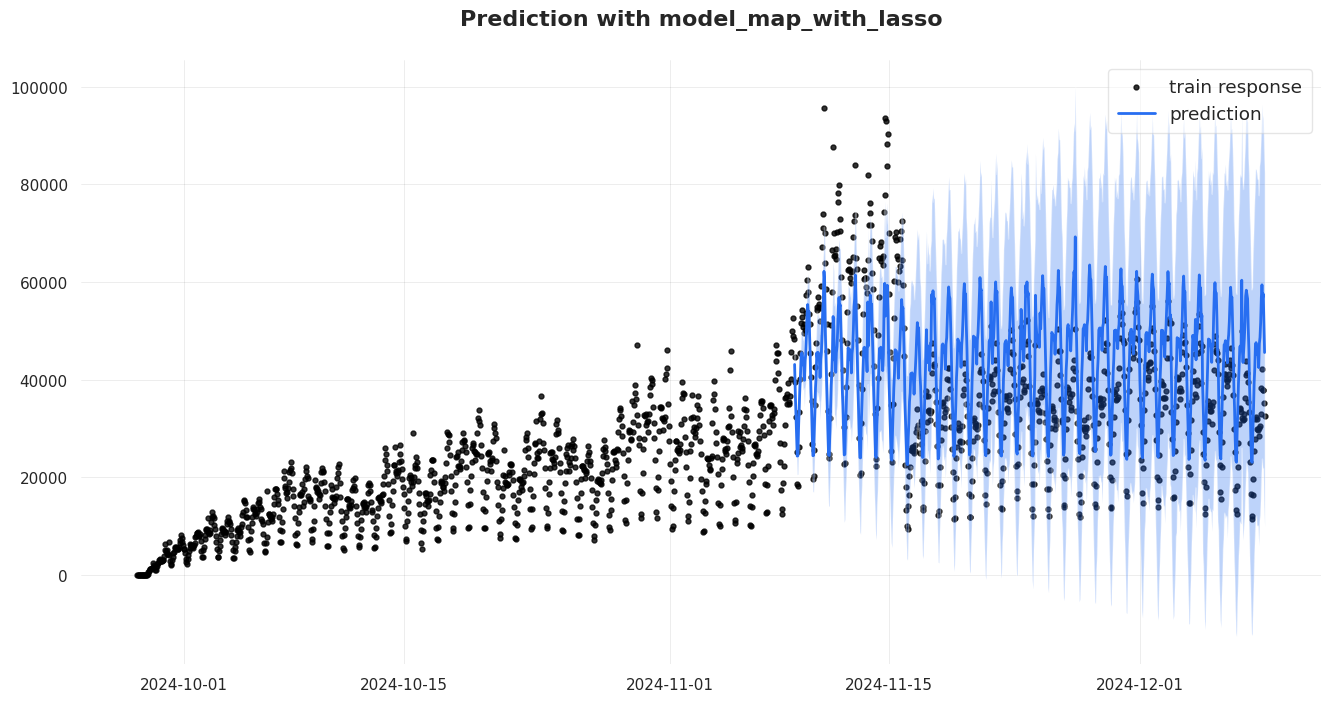

<Axes: title={'center': 'Prediction with model_map_with_lasso'}>

In [98]:
model_map_with_lasso_predicted_df = model_map_with_lasso.predict(df=test_df, decompose=True)
plot_predicted_data(df, #изначальные данные
                        model_map_with_lasso_predicted_df, #датафрейм с предсказаниями
                        "hour_date", #колонка со временем
                        'actions', #колонка со значениями временного ряда
                        title='Prediction with model_map_with_lasso') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

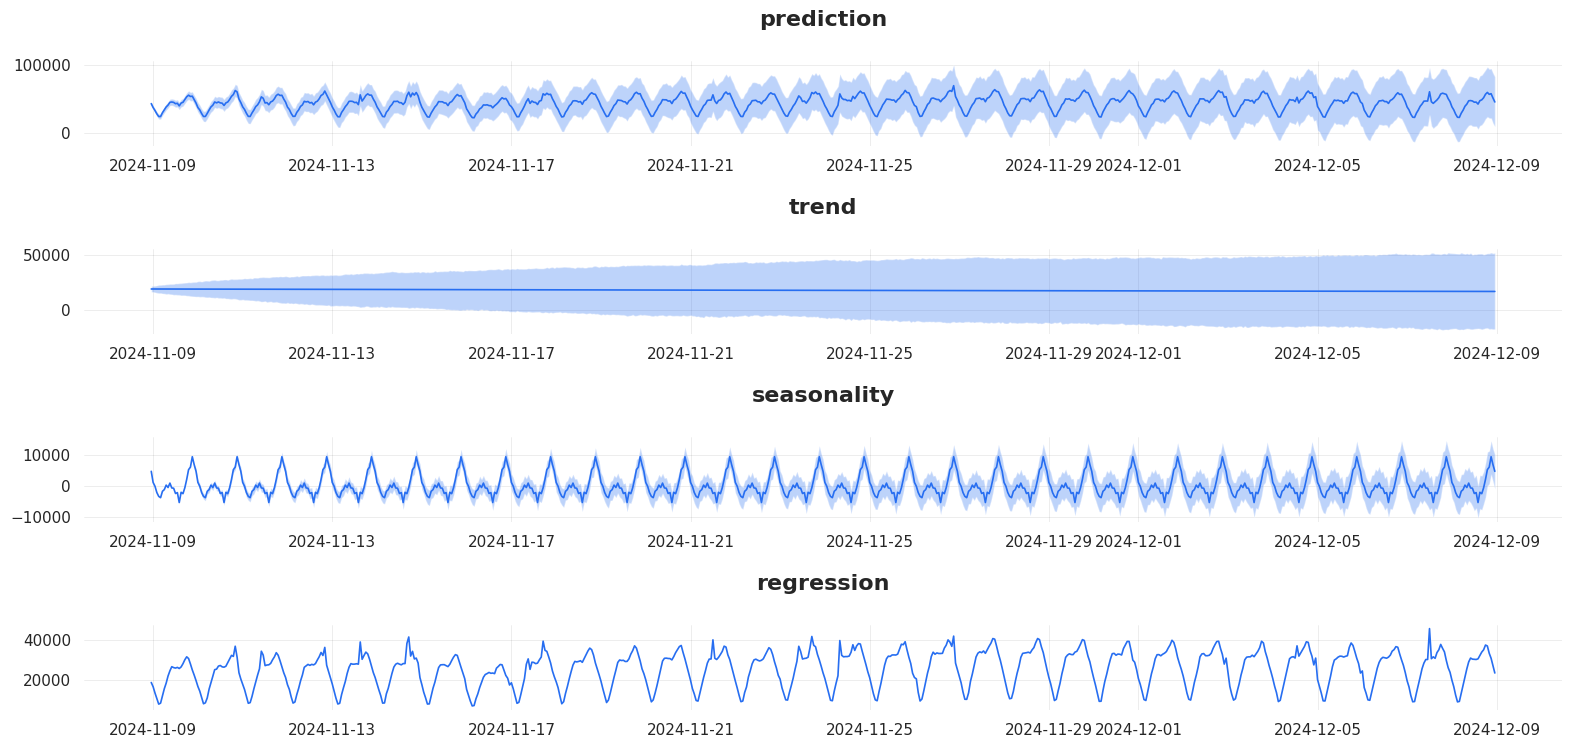

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>,
       <Axes: title={'center': 'regression'}>], dtype=object)

In [99]:
plot_predicted_components(model_map_with_lasso_predicted_df, "hour_date", plot_components=['prediction', 'trend', 'seasonality', 'regression'])

* Построим модель на основе алгоритма 'stan-mcmc':

In [72]:
model_mcmc = DLT(response_col="actions", #название колонки с метрикой
                 date_col="hour_date", #название колонки с датами-временем
                 seasonality=24, #длина периода сезонности 
                 estimator="stan-mcmc", #алгоритм оценки
                 num_warmup=1000, # время для разогрева
                 num_sample=1000, # время сэмплирования
                 global_trend_option='logistic',
                 global_cap=100000,
                 global_floor=0
                ) 

model_mcmc.fit(train_df)

2024-12-09 13:50:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

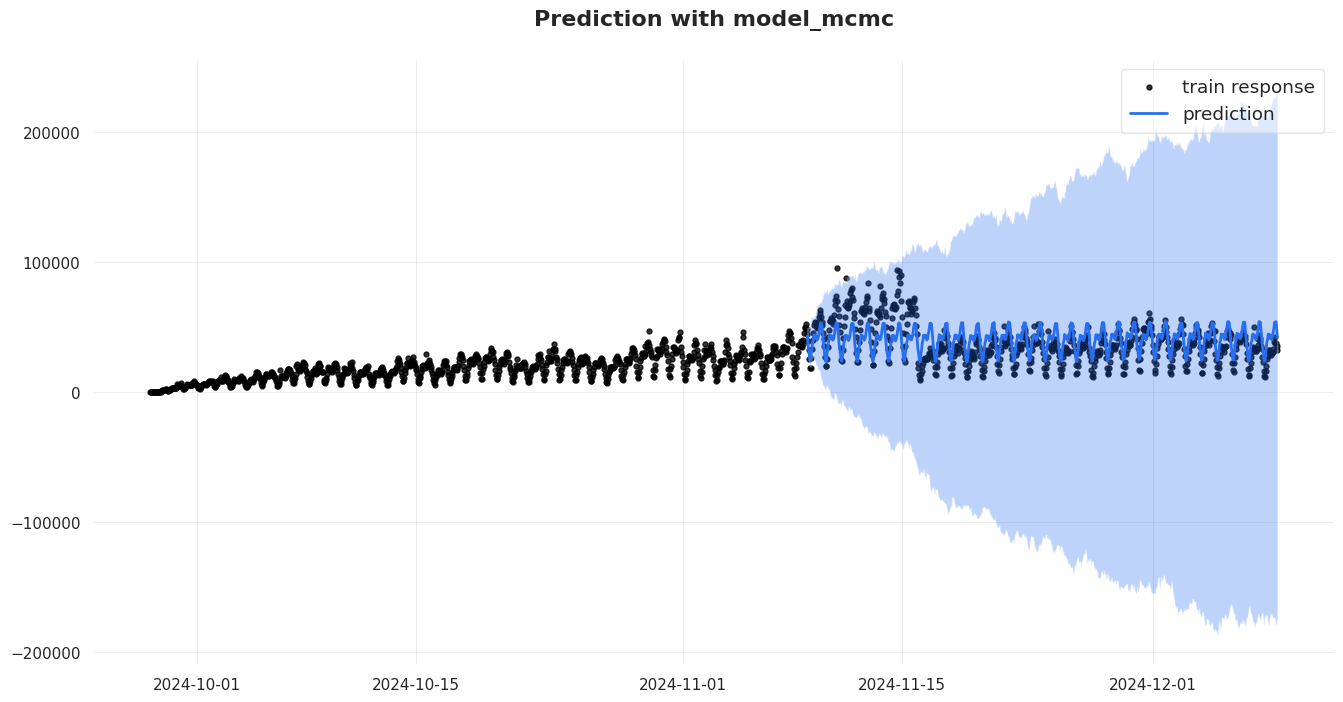

<Axes: title={'center': 'Prediction with model_mcmc'}>

In [73]:
model_mcmc_predicted_df = model_mcmc.predict(df=test_df, decompose=True)

plot_predicted_data(df, #изначальные данные
                    model_mcmc_predicted_df, #датафрейм с предсказаниями
                    "hour_date", #колонка со временем
                    'actions', #колонка со значениями временного ряда
                    title='Prediction with model_mcmc') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

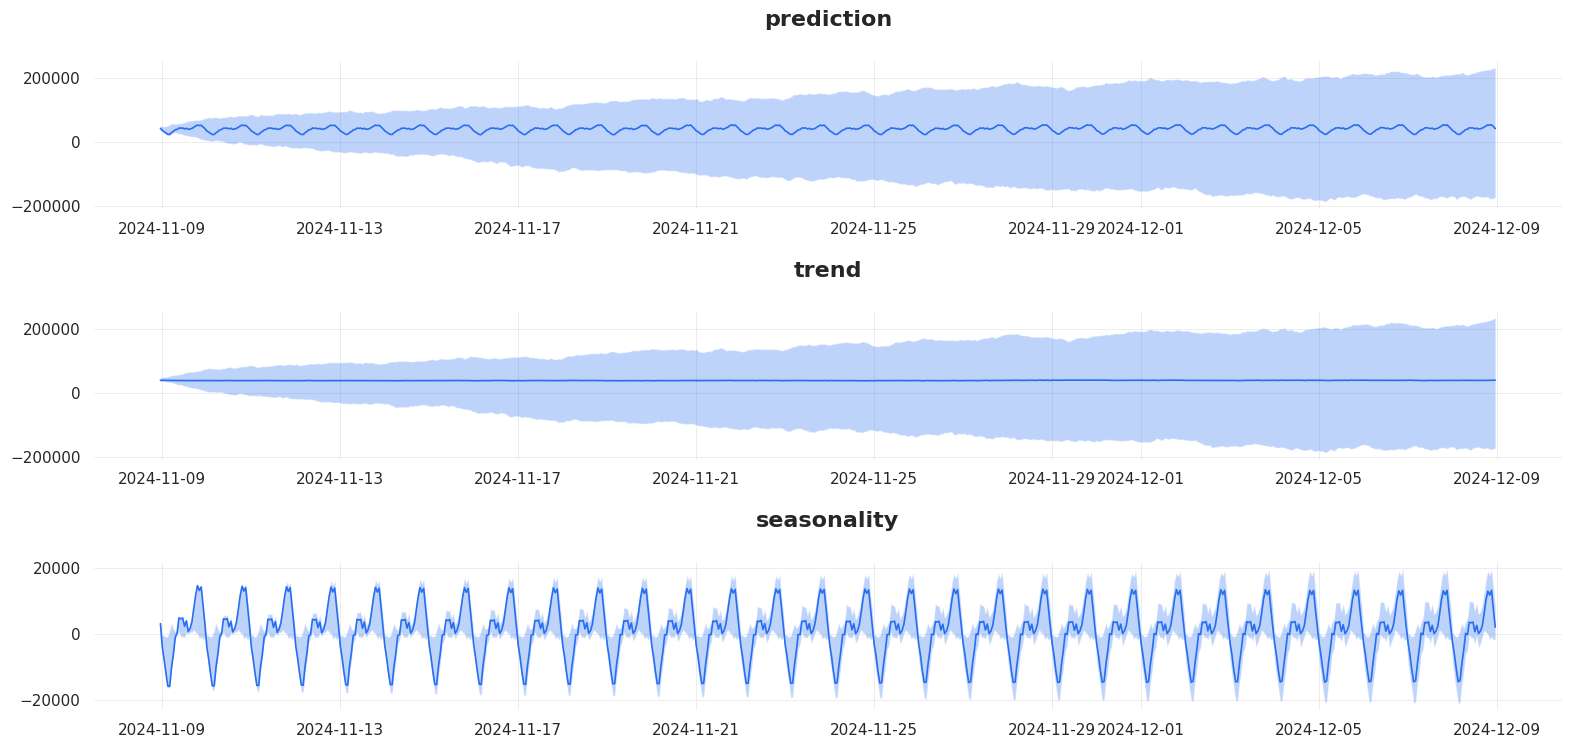

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>], dtype=object)

In [74]:
plot_predicted_components(model_mcmc_predicted_df, "hour_date", plot_components=['prediction', 'trend', 'seasonality'])

* Построим модель на основе алгоритма 'stan-mcmc' с регрессором DAU и регуляцией по умолчанию:

In [75]:
model_mcmc_with_regressor = DLT(response_col="actions", #название колонки с метрикой
                                date_col="hour_date", #название колонки с датами-временем
                                seasonality=24, #длина периода сезонности 
                                estimator="stan-mcmc", #алгоритм оценки
                                num_warmup=1000, # время для разогрева
                                num_sample=1000, # время сэмплирования
                                regressor_col=["users"], #наша колонка с регрессором! Должна быть списком
                                regressor_sign=["+"], # знак коэффициента регрессии, ожидаем только положительные значения
                                regression_penalty='fixed_ridge', # вид регуляризации = полагаться на заданные априорные распределения
                                global_trend_option='logistic',
                                global_cap=100000,
                                global_floor=1
                               )  

model_mcmc_with_regressor.fit(train_df)

2024-12-09 13:56:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

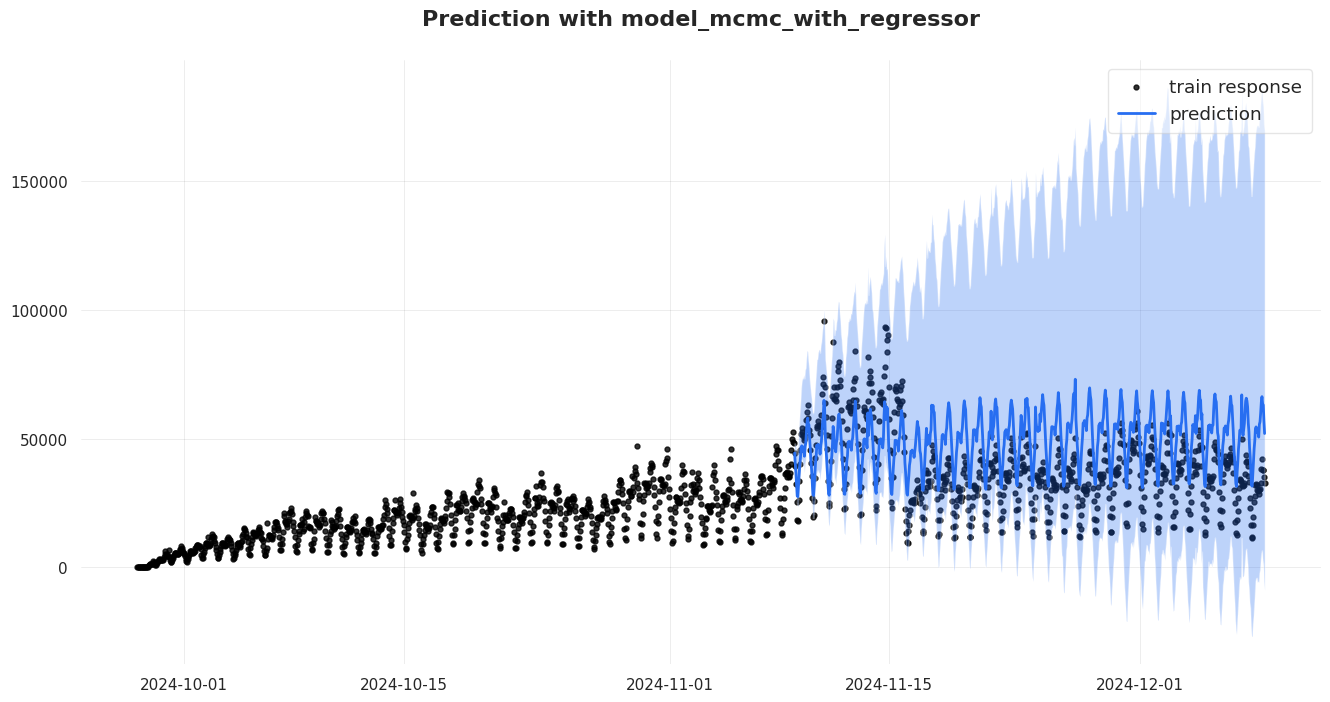

<Axes: title={'center': 'Prediction with model_mcmc_with_regressor'}>

In [76]:
model_mcmc_with_regressor_predicted_df = model_mcmc_with_regressor.predict(df=test_df, decompose=True)
plot_predicted_data(df, #изначальные данные
                    model_mcmc_with_regressor_predicted_df, #датафрейм с предсказаниями
                    "hour_date", #колонка со временем
                    'actions', #колонка со значениями временного ряда
                    title='Prediction with model_mcmc_with_regressor') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

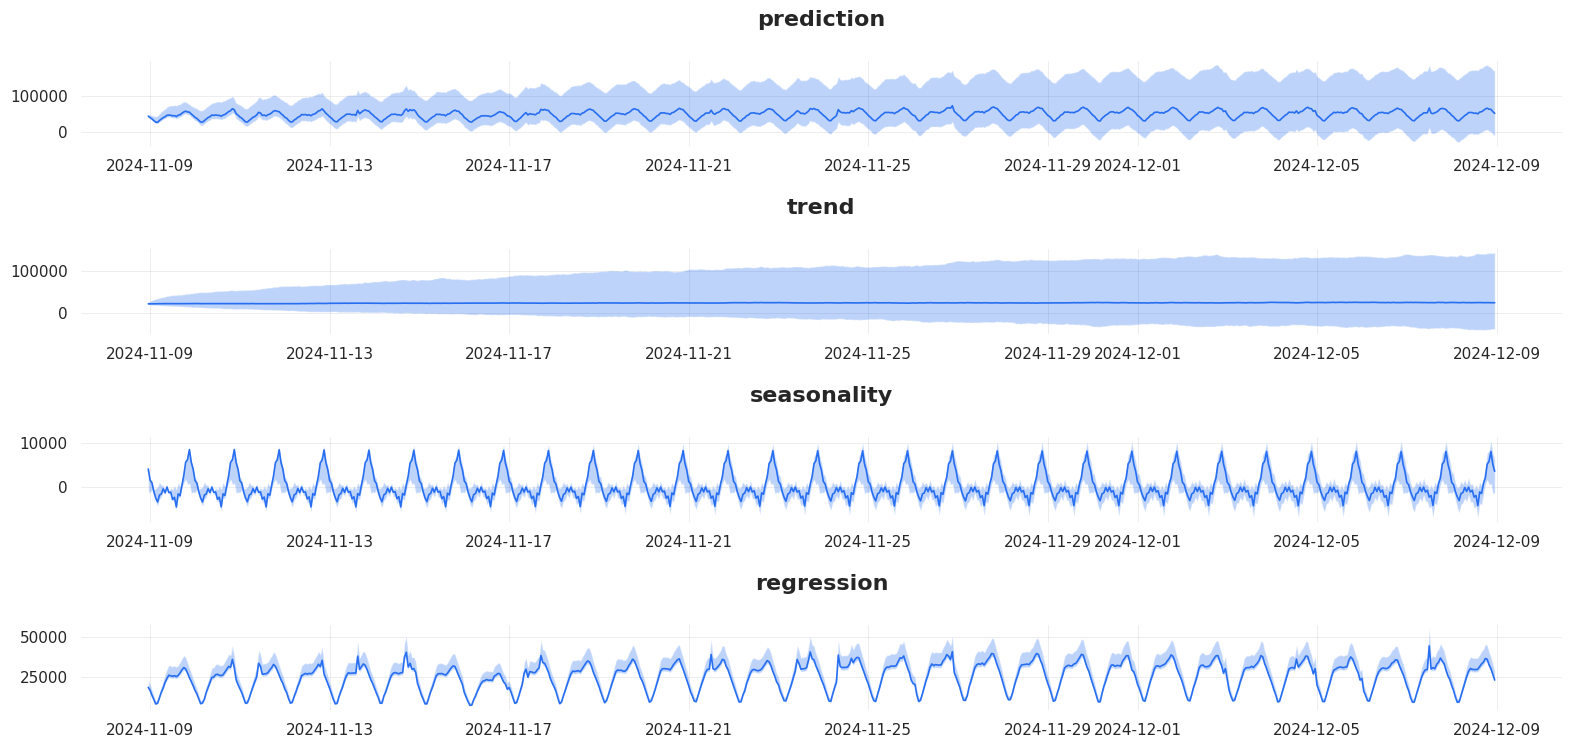

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>,
       <Axes: title={'center': 'regression'}>], dtype=object)

In [77]:
plot_predicted_components(model_mcmc_with_regressor_predicted_df, "hour_date", plot_components=['prediction', 'trend', 'seasonality', 'regression'])

* Построим модель на основе алгоритма 'stan-mcmc' с регрессором DAU и с авто подбором оптимальной регуляризации:

In [78]:
model_mcmc_with_auto_ridge = DLT(response_col="actions", #название колонки с метрикой
                                 date_col="hour_date", #название колонки с датами-временем
                                 seasonality=24, #длина периода сезонности 
                                 estimator="stan-mcmc", #алгоритм оценки
                                 num_warmup=1000, # время для разогрева
                                 num_sample=1000, # время сэмплирования
                                 regressor_col=["users"], #наша колонка с регрессором! Должна быть списком
                                 regressor_sign=["+"], # знак коэффициента регрессии, ожидаем только положительные значения
                                 regression_penalty='auto_ridge', # вид регуляризации = авто подбор оптимальной регуляризации
                                 global_trend_option='logistic',
                                 global_cap=100000,
                                 global_floor=1
                                ) 

model_mcmc_with_auto_ridge.fit(train_df)

2024-12-09 14:00:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

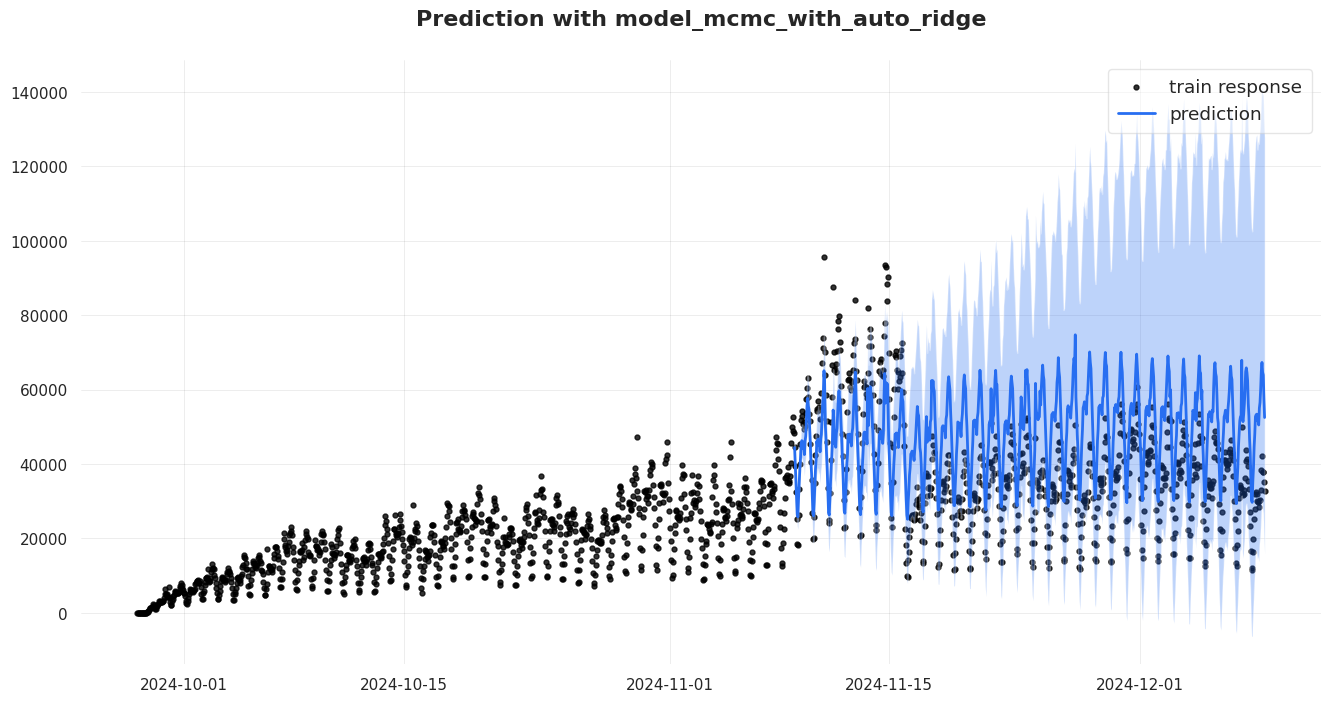

<Axes: title={'center': 'Prediction with model_mcmc_with_auto_ridge'}>

In [79]:
model_mcmc_with_auto_ridge_predicted_df = model_mcmc_with_auto_ridge.predict(df=test_df, decompose=True)

plot_predicted_data(df, #изначальные данные
                    model_mcmc_with_auto_ridge_predicted_df, #датафрейм с предсказаниями
                    "hour_date", #колонка со временем
                    'actions', #колонка со значениями временного ряда
                    title='Prediction with model_mcmc_with_auto_ridge') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

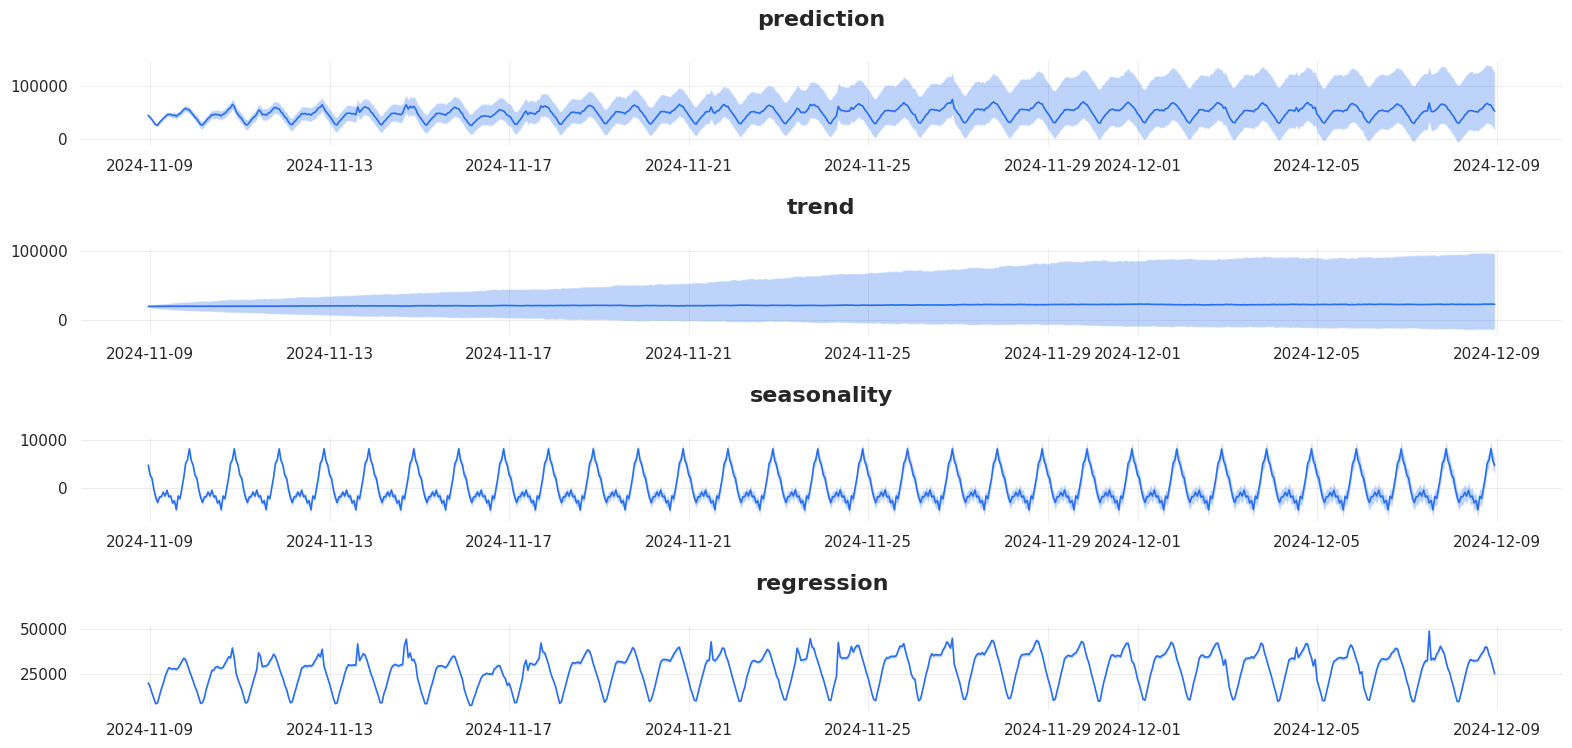

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>,
       <Axes: title={'center': 'regression'}>], dtype=object)

In [80]:
plot_predicted_components(model_mcmc_with_auto_ridge_predicted_df, "hour_date", plot_components=['prediction', 'trend', 'seasonality', 'regression'])

* Построим модель на основе алгоритма 'stan-mcmc' с регрессором DAU и с упразднением влияния плохих регрессоров:

In [81]:
model_mcmc_with_lasso = DLT(response_col="actions", #название колонки с метрикой
                            date_col="hour_date", #название колонки с датами-временем
                            seasonality=24, #длина периода сезонности 
                            estimator="stan-mcmc", #алгоритм оценки
                            num_warmup=1000, # время для разогрева
                            num_sample=1000, # время сэмплирования
                            regressor_col=["users"], #наша колонка с регрессором! Должна быть списком
                            regressor_sign=["+"], # знак коэффициента регрессии, ожидаем только положительные значения
                            regression_penalty='lasso', # вид регуляризации = “убирает” влияние плохих регрессоров
                            global_trend_option='logistic',
                            global_cap=10000,
                            global_floor=1
                           ) 

model_mcmc_with_lasso.fit(train_df)

2024-12-09 14:03:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

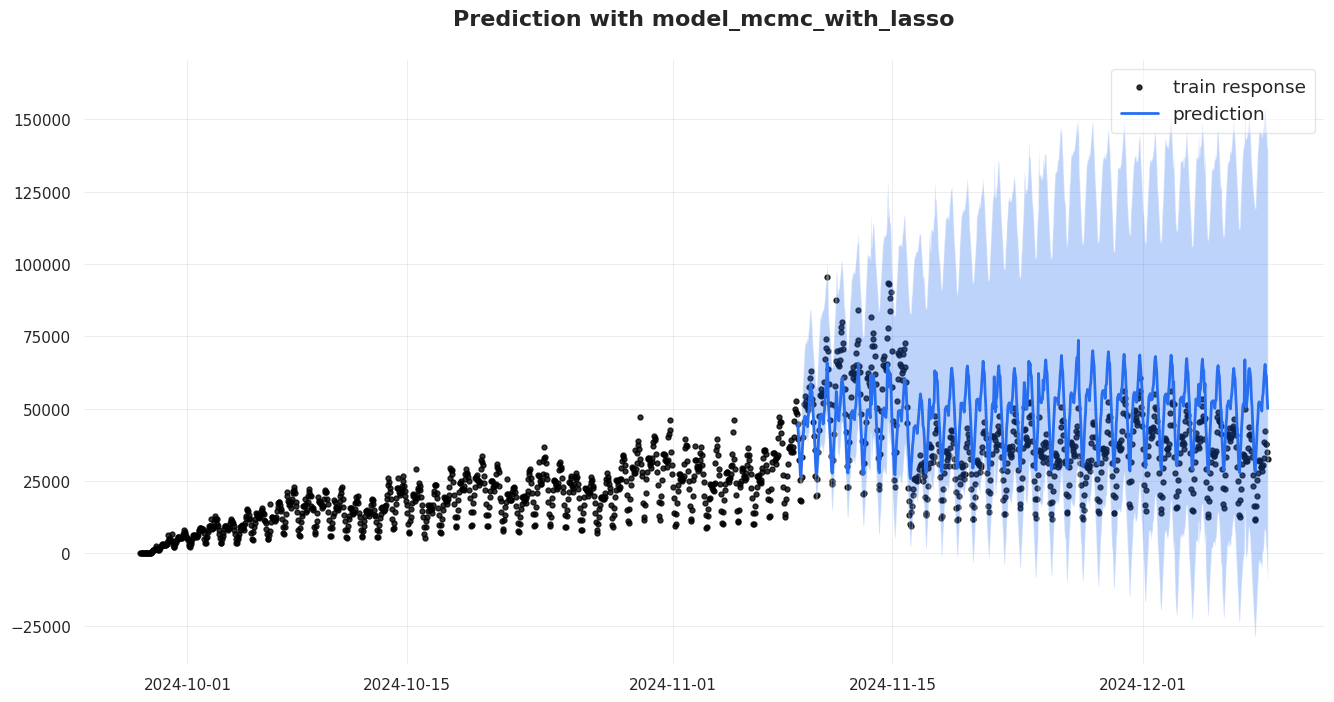

<Axes: title={'center': 'Prediction with model_mcmc_with_lasso'}>

In [82]:
model_mcmc_with_lasso_predicted_df = model_mcmc_with_lasso.predict(df=test_df, decompose=True)

plot_predicted_data(df, #изначальные данные
                    model_mcmc_with_lasso_predicted_df, #датафрейм с предсказаниями
                    "hour_date", #колонка со временем
                    'actions', #колонка со значениями временного ряда
                    title='Prediction with model_mcmc_with_lasso') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

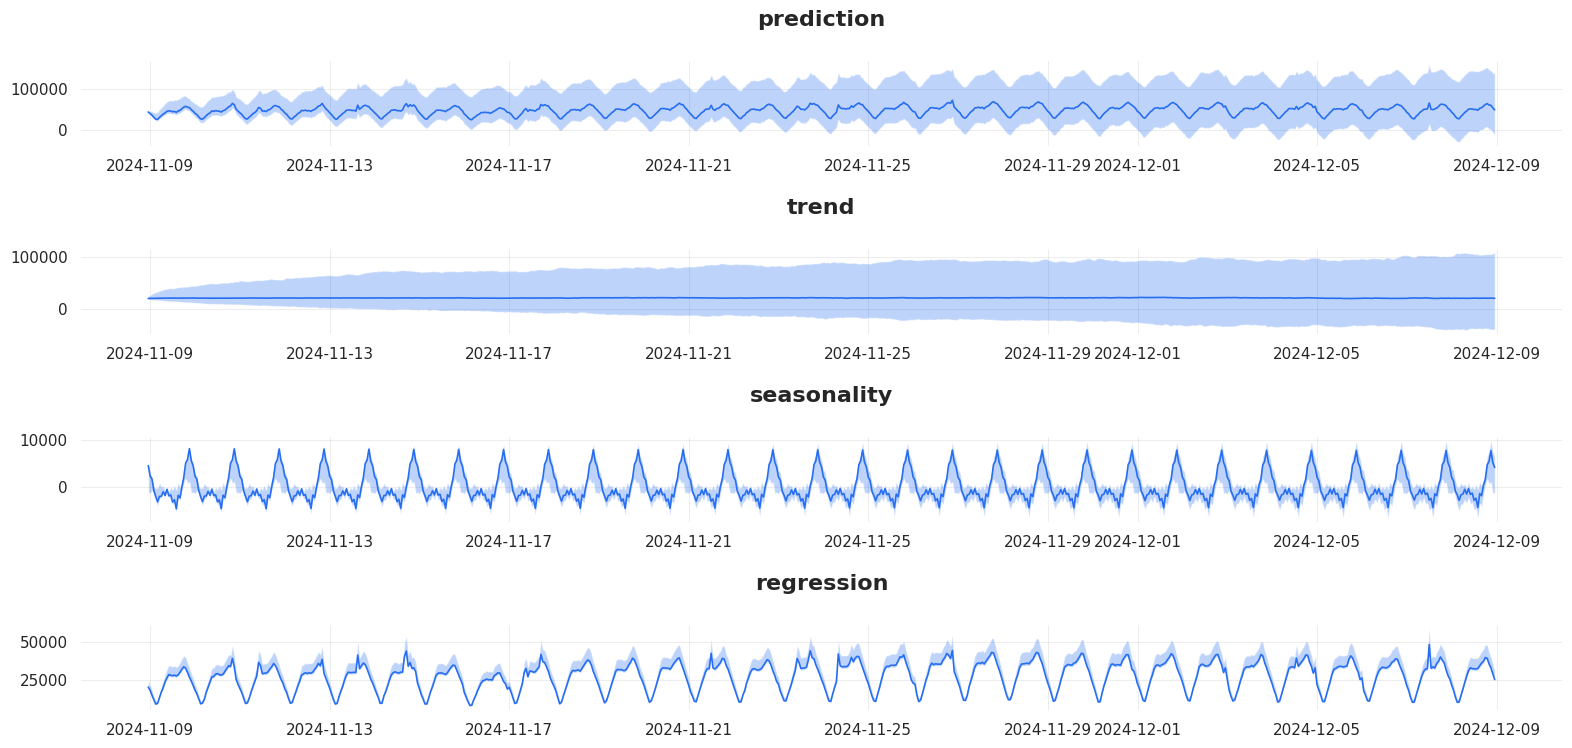

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>,
       <Axes: title={'center': 'regression'}>], dtype=object)

In [83]:
plot_predicted_components(model_mcmc_with_lasso_predicted_df, "hour_date", plot_components=['prediction', 'trend', 'seasonality', 'regression'])

In [84]:
model_mcmc.fit_wbic(train_df)

2024-12-09 14:08:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 6.915, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17886.687887747757

In [85]:
model_mcmc_with_regressor.fit_wbic(train_df)

2024-12-09 14:09:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 6.915, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17404.673335322663

In [86]:
model_mcmc_with_auto_ridge.fit_wbic(train_df)

2024-12-09 14:10:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 6.915, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16733.561793565823

In [87]:
model_mcmc_with_lasso.fit_wbic(train_df)

2024-12-09 14:12:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 6.915, warmups (per chain): 250 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16775.607402141053

Оценка моделей:

In [101]:
print(f"Алгоритм map без регрессора: {model_map.get_bic()}")
print(f"Алгоритм map с регрессором: {model_map_with_regressor.get_bic()}")
print(f"Алгоритм map с регрессором и авто регуляризацией: {model_map_with_auto_ridge.get_bic()}")
print(f"Алгоритм map с регрессором и упразднением плохих регресоров: {model_map_with_lasso.get_bic()}")
print(f"--------------------------")
print(f"Алгоритм mcmc без регрессора: {model_mcmc.get_wbic()}")
print(f"Алгоритм mcmc с регрессором: {model_mcmc_with_regressor.get_wbic()}")
print(f"Алгоритм mcmc с регрессором и авто регуляризацией: {model_mcmc_with_auto_ridge.get_wbic()}")
print(f"Алгоритм mcmc с регрессором и упразднением плохих регресоров: {model_mcmc_with_lasso.get_wbic()}")


Алгоритм map без регрессора: 17767.485168207917
Алгоритм map с регрессором: 17774.55992555858
Алгоритм map с регрессором и авто регуляризацией: 18067.261525558573
Алгоритм map с регрессором и упразднением плохих регресоров: 17127.82574555858
--------------------------
Алгоритм mcmc без регрессора: 17886.687887747757
Алгоритм mcmc с регрессором: 17404.673335322663
Алгоритм mcmc с регрессором и авто регуляризацией: 16733.561793565823
Алгоритм mcmc с регрессором и упразднением плохих регресоров: 16775.607402141053


In [102]:
print(f"Алгоритм map без регрессора: {rmsse(test_df.actions.values, model_map_predicted_df.prediction.values, train_df.actions.values)}")
print(f"Алгоритм map с регрессором: {rmsse(test_df.actions.values, model_map_with_regressor_predicted_df.prediction.values, train_df.actions.values)}")
print(f"Алгоритм map с регрессором и авто регуляризацией: {rmsse(test_df.actions.values, model_map_with_auto_ridge_predicted_df.prediction.values, train_df.actions.values)}")
print(f"Алгоритм map с регрессором и упразднением плохих регресоров: {rmsse(test_df.actions.values, model_map_with_lasso_predicted_df.prediction.values, train_df.actions.values)}")
print(f"--------------------------")
print(f"Алгоритм mcmc без регрессора: {rmsse(test_df.actions.values, model_mcmc_predicted_df.prediction.values, train_df.actions.values)}")
print(f"Алгоритм mcmc с регрессором: {rmsse(test_df.actions.values, model_mcmc_with_regressor_predicted_df.prediction.values, train_df.actions.values)}")
print(f"Алгоритм mcmc с регрессором и авто регуляризацией: {rmsse(test_df.actions.values, model_mcmc_with_auto_ridge_predicted_df.prediction.values, train_df.actions.values)}")
print(f"Алгоритм mcmc с регрессором и упразднением плохих регресоров: {rmsse(test_df.actions.values, model_mcmc_with_lasso_predicted_df.prediction.values, train_df.actions.values)}")

Алгоритм map без регрессора: 1.9602686128192193
Алгоритм map с регрессором: 1.9601733361731675
Алгоритм map с регрессором и авто регуляризацией: 2.076347899098369
Алгоритм map с регрессором и упразднением плохих регресоров: 2.3136160233141827
--------------------------
Алгоритм mcmc без регрессора: 2.0942359660440184
Алгоритм mcmc с регрессором: 3.0273822933343393
Алгоритм mcmc с регрессором и авто регуляризацией: 2.9282193875237144
Алгоритм mcmc с регрессором и упразднением плохих регресоров: 2.861795359542026


Учитывая, что rmsse выдает оценку предсказания с учетом его сравнения с реальными данными, предлагаю, больше доверять этой оценке. 

С наименьшим значением "ошибочности" лучше выглядят две модели: Алгоритм map без регрессора и Алгоритм map с регрессором. Т.к. значения почти одинаковые, предлагаю взять для будущего прогноза моедль map без регрессора. Будет проще, т.к. не нужно будет предсказывать будущие значения регрессора.

* посмотрим модель на основе алгоритма 'stan-map' без регрессора:

In [103]:
model_map_prod = DLT(response_col="actions", #название колонки с метрикой
                date_col="hour_date", #название колонки с датами-временем
                seasonality=24, #длина периода сезонности 
                estimator="stan-map", #алгоритм оценки
                n_bootstrap_draws=1000, #количество сэмплов бутстрапа для доверительного интервала
                global_trend_option='logistic',
                global_cap=100000,
                global_floor=1
               ) 

model_map_prod.fit(df)

2024-12-09 14:47:01 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [104]:
future_df = model_map_prod.make_future_df(periods=24*30) 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

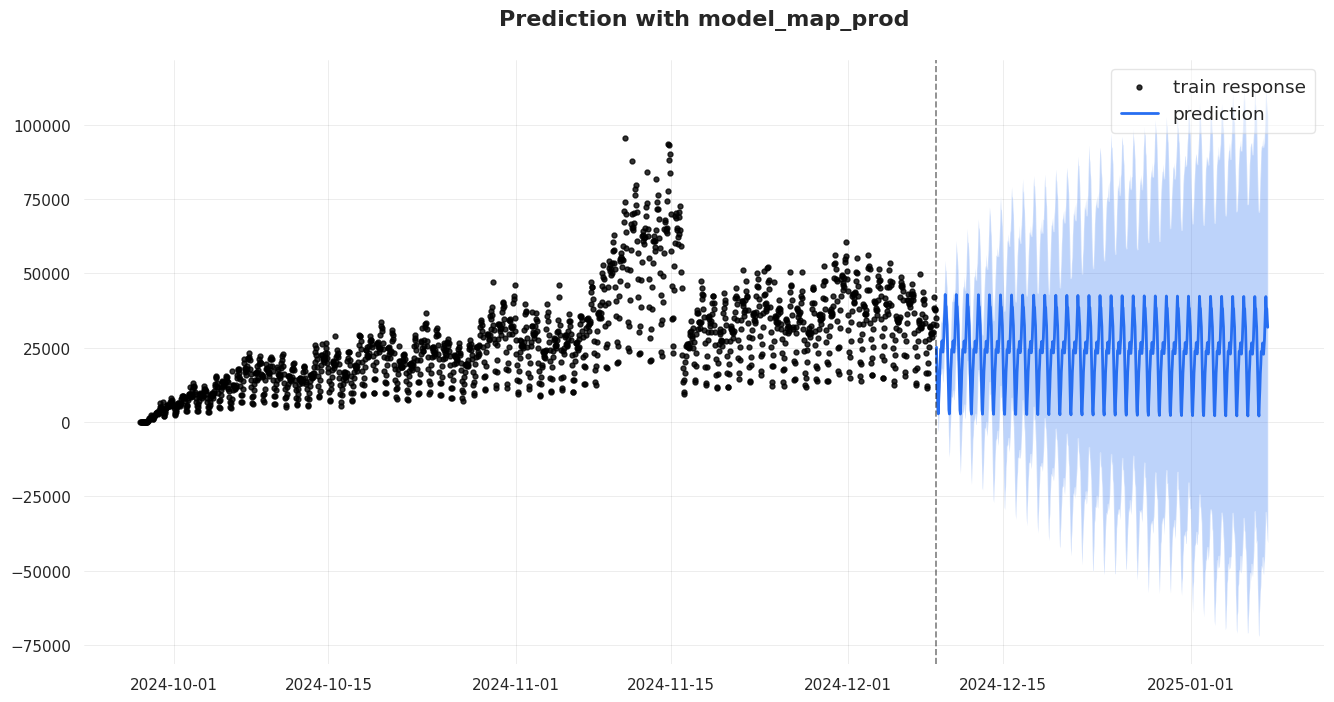

<Axes: title={'center': 'Prediction with model_map_prod'}>

In [105]:
predicted_df_prod = model_map_prod.predict(df=future_df, decompose=True)

plot_predicted_data(df, #изначальные данные
                    predicted_df_prod, #датафрейм с предсказаниями
                    "hour_date", #колонка со временем
                    'actions', #колонка со значениями временного ряда
                    title='Prediction with model_map_prod') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

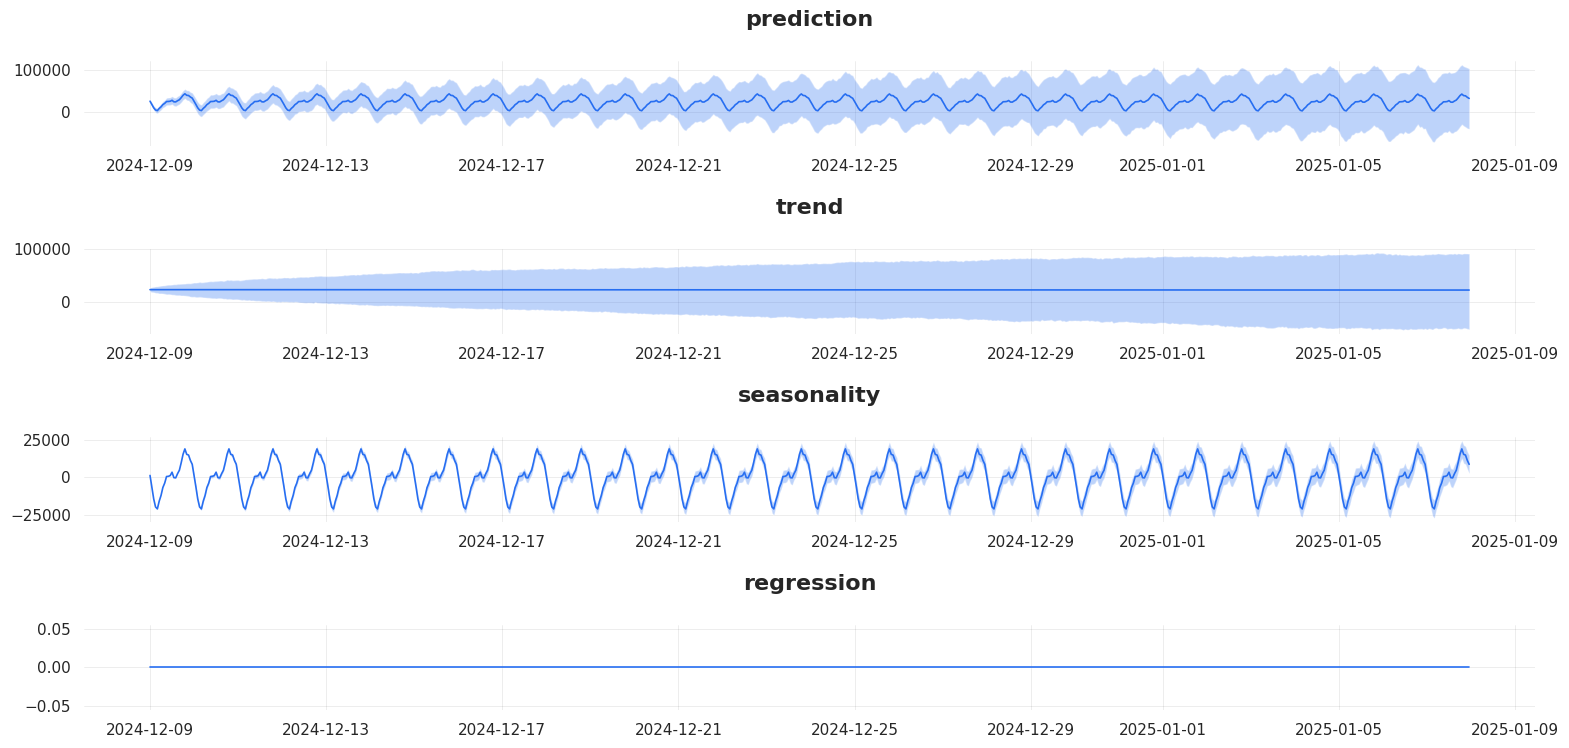

array([<Axes: title={'center': 'prediction'}>,
       <Axes: title={'center': 'trend'}>,
       <Axes: title={'center': 'seasonality'}>,
       <Axes: title={'center': 'regression'}>], dtype=object)

In [106]:
plot_predicted_components(predicted_df_prod, "hour_date", plot_components=['prediction', 'trend', 'seasonality', 'regression'])

* Проведем бэктестинг полученной модели:

In [110]:
bt_exp = BackTester(
    model=model_map_prod, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=24*30, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24*30, #горизонт прогнозирования
    window_type='expanding' #тип окошка
)

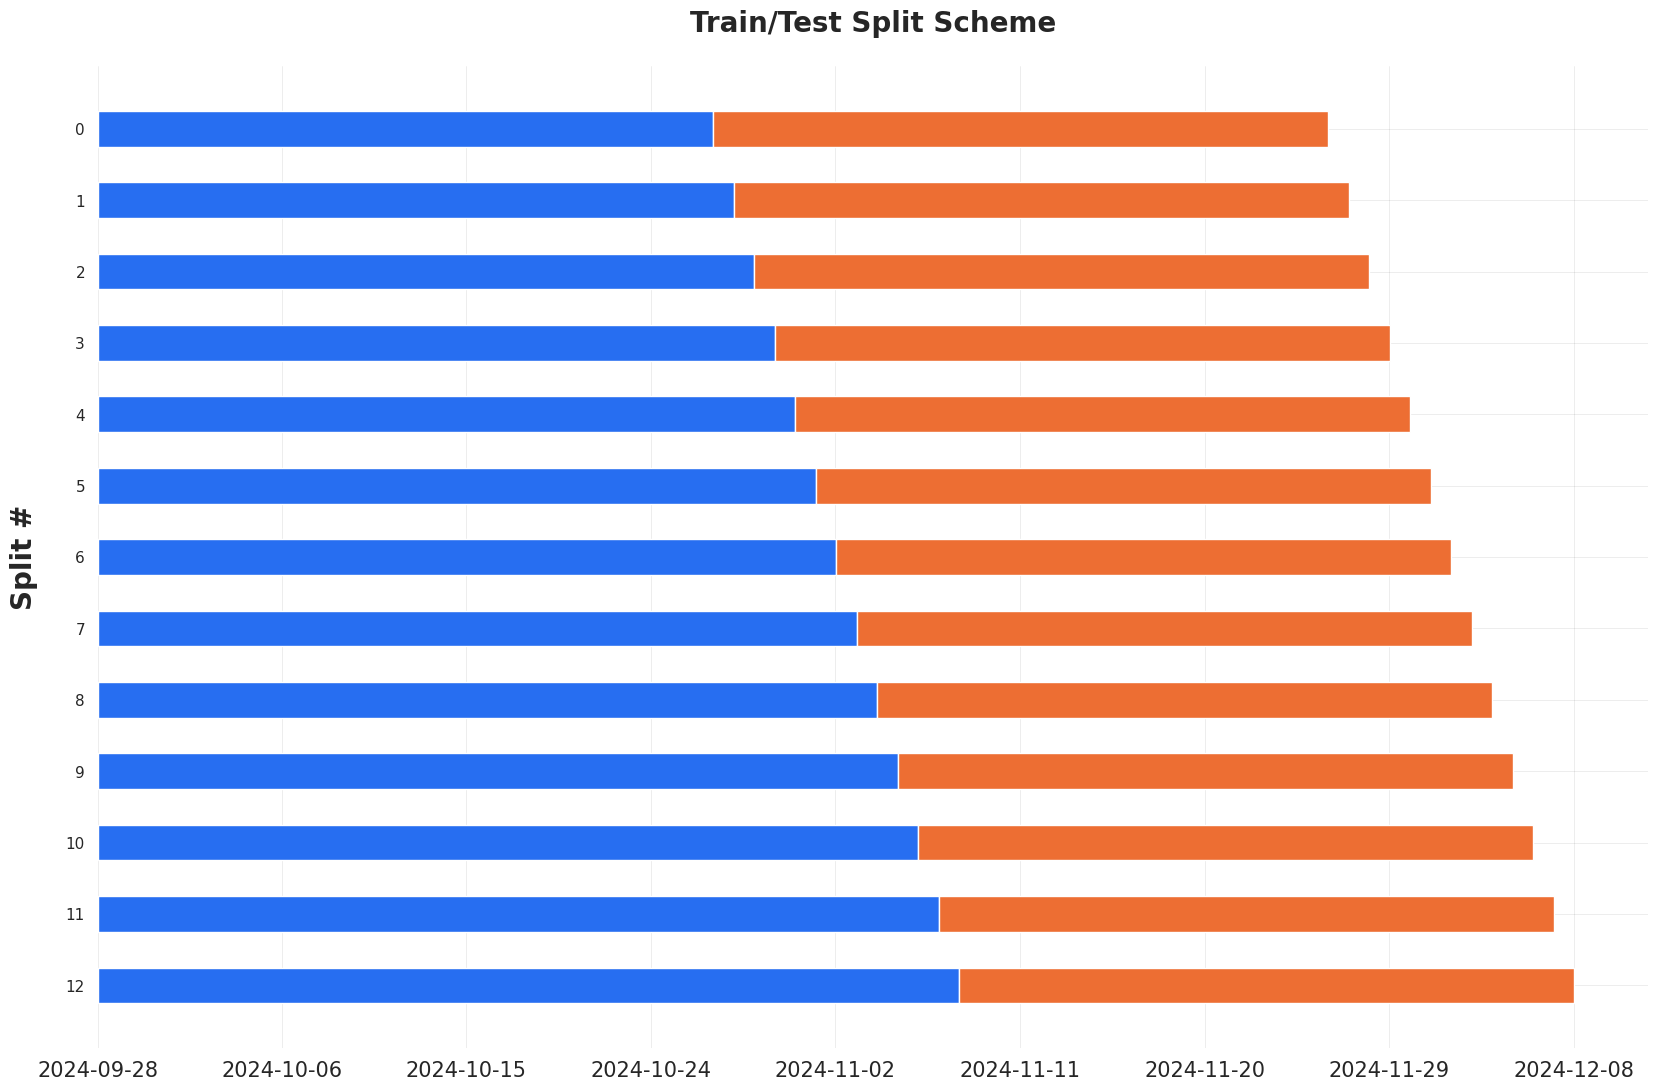

In [111]:
bt_exp.plot_scheme()

Как видим, данных для бэктестинга хватает.

In [112]:
bt_exp.fit_predict() #обучаем
bt_exp.score() #выводим метрики

metric_name  metric_values  is_training_metric
0       smape   3.243534e-01               False
1       wmape   3.185240e-01               False
2        mape   3.176191e-01               False
3         mse   2.526053e+08               False
4         mae   1.173794e+04               False
5       rmsse   2.915858e+00               False

* Посмотрим полученные предсказания:

In [108]:
predicted_df_prod.prediction.describe()

count      720.000000
mean     23824.402159
std      11097.309425
min       2020.363135
25%      16902.216983
50%      24422.589740
75%      32674.307602
max      42902.868800
Name: prediction, dtype: float64

<Axes: xlabel='hour_date', ylabel='prediction'>

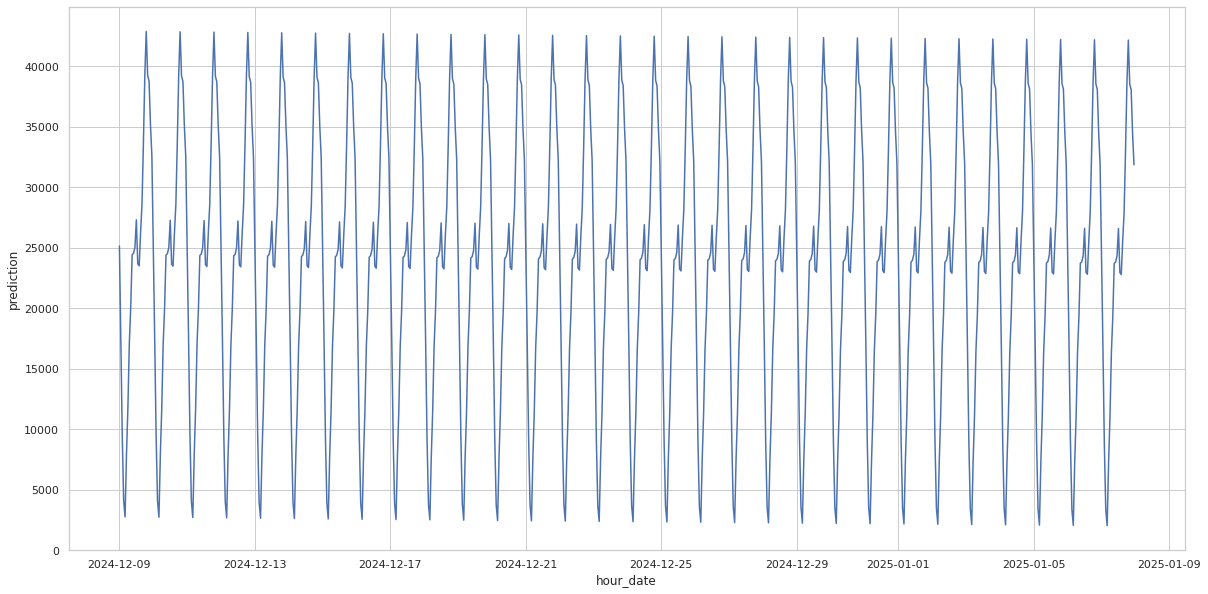

In [109]:
sns.lineplot(data=predicted_df_prod, x='hour_date', y='prediction')

Исходя из полученных результатов, мы предполагаем, что тренд по активности пользователей и, соответственно, нагрузки на сервер в ближайших месяц останется на прежнем уровне. Предлагаем передать полученный датафрейм predicted_df_prod нашим инженерам для учета в работе по оптимизации нагрузки. Здесь важно подчеркнуть, что полученная модель не имеет высоких оценок качества, вероятно, из-за наблюдаемого "искусственного" всплеска активности в период флешмоба. Поэтому говорить о точном прогнозе не приходится.

*В первый раз в своей жизни что-то прогнозирую с помощью программного кода.
Orbit в принципе стал понятен (основные принципы), наверное, в течении 1 дня практики написания кода. Первое что непонятно и неудобно, это прогнозирование регрессоров (в черновиках пытался прогнозировать DAU, в итоге какие-то непонятные результаты получились). Также плохо понял наличие отрицательных значений при логистическом тренде в некоторых моделях.*